In [1]:
import pathlib

import hubbardml
from hubbardml import keys, plots, similarities
import numpy as np
import torch

hubbardml.utils.random_seed()

dtype = torch.float32
torch.set_default_dtype(dtype)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device, torch.get_default_dtype()

('cuda', torch.float32)

In [2]:
VALIDATE_PERCENTAGE = 0.2
DATASET = "../data/data_uv_unique_inout_2023_2_8.json"
DATASET = "../data/data_uv_2023_8_2.json"

SAVEFIGS = False
TARGET_PARAM = 'U'


def plotfile(label: str):
    return f'plots/{DATASET}_{label}.pdf'

In [3]:
df = hubbardml.datasets.load(DATASET)

## Input creation

Filter the DF to keep things we want

In [4]:
species = list(df[keys.ATOM_1_ELEMENT].unique())
# species = ("Mn", "Fe", "Ni")
graph = hubbardml.graphs.UGraph(species)

df = graph.prepare_dataset(df)
print(len(df))

df = graph.identify_duplicates(
    df,
    # tolerances=dict(occs_tol=2e-4, param_tol=1e-3)
)
print(len(df[df[keys.TRAINING_LABEL] == keys.DUPLICATE]))
print(len(df[similarities.CLUSTER_ID].unique()))

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


677


/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


379
298


In [5]:
print(f"Data splits set:\n{df[keys.TRAINING_LABEL].value_counts()}")

Data splits set:
duplicate    379
Name: training_label, dtype: int64


## Model creation

In [6]:
model = hubbardml.models.UModel(
    graph,
    feature_irreps="4x0e + 4x1e + 4x2e+ 4x3e",
    hidden_layers=2,
    rescaler=hubbardml.models.Rescaler.from_data(df[keys.PARAM_OUT], method="mean"),
    irrep_normalization="component",
)
model.to(dtype=dtype, device=device)

/home/martin/.local/miniconda3/envs/dftuv/lib/python3.10/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


UModel(
  (layers): ModuleList(
    (0): TensorSquare(8x0e+1x2e+1x4e+2x0e+1x2e+1x4e+1x0e+1x2e+1x4e+1x6e+1x8e+1x0e -> 16x0e+4x1e+4x2e+4x3e | 1824 paths | 1824 weights)
    (1): Gate (16x0e+4x1e+4x2e+4x3e -> 4x0e+4x1e+4x2e+4x3e)
    (2): TensorSquare(4x0e+4x1e+4x2e+4x3e -> 16x0e+4x1e+4x2e+4x3e | 1584 paths | 1584 weights)
    (3): Gate (16x0e+4x1e+4x2e+4x3e -> 4x0e+4x1e+4x2e+4x3e)
    (4): TensorSquare(4x0e+4x1e+4x2e+4x3e -> 1x0e | 40 paths | 40 weights)
    (5): Rescaler(shift=7.280406056129985,scale=1.808925863209305)
  )
)

## Split test/train

In [7]:
# hubbardml.datasets.split(df, method='category', frac=0.2, category=["species"])
df = hubbardml.datasets.split_by_cluster(
    df, 
    frac=0.2, 
    category=["species", keys.SC_PATHS], 
    ignore_already_labelled=True
)

In [8]:
# Get the indices of the training and validation data
train_idx = df[df[keys.TRAINING_LABEL] == keys.TRAIN].index
validate_idx = df[df[keys.TRAINING_LABEL] == keys.VALIDATE].index

print(df.groupby([keys.TRAINING_LABEL, keys.ATOM_1_ELEMENT]).size())

training_label  atom_1_element
duplicate       Fe                  3
                Mn                 42
                Ni                 29
train           Co                  4
                Fe                 93
                Mn                226
                Ni                214
                Ti                  4
validate        Co                  1
                Fe                 20
                Mn                 28
                Ni                 13
dtype: int64


In [22]:
trainer = hubbardml.Trainer.from_frame(
    model=model,
    opt=torch.optim.AdamW(model.parameters(), lr=0.01),
    loss_fn=torch.nn.MSELoss(),
    frame=df,
    target_column=keys.PARAM_OUT,
    batch_size=128,
)

In [33]:
trainer.overfitting_window = 400

trainer.train(
    callback=lambda trainer: print(trainer.status()),
    callback_period=50,
    max_epochs=10_000,
)

epoch: 10000 train: mse 0.09614, valid: mse 0.11321 rmse 0.3365
epoch: 10050 train: mse 0.10707, valid: mse 0.12810 rmse 0.3579
epoch: 10100 train: mse 0.09712, valid: mse 0.11906 rmse 0.3451
epoch: 10150 train: mse 0.10314, valid: mse 0.13923 rmse 0.3731
epoch: 10200 train: mse 0.11483, valid: mse 0.14537 rmse 0.3813
epoch: 10250 train: mse 0.12820, valid: mse 0.12622 rmse 0.3553
epoch: 10300 train: mse 0.08973, valid: mse 0.11527 rmse 0.3395
epoch: 10350 train: mse 0.08820, valid: mse 0.11314 rmse 0.3364
epoch: 10400 train: mse 0.11217, valid: mse 0.12010 rmse 0.3466
epoch: 10450 train: mse 0.09440, valid: mse 0.11867 rmse 0.3445
epoch: 10500 train: mse 0.09389, valid: mse 0.11864 rmse 0.3444
epoch: 10550 train: mse 0.11362, valid: mse 0.13388 rmse 0.3659
epoch: 10600 train: mse 0.11040, valid: mse 0.13183 rmse 0.3631
epoch: 10650 train: mse 0.12114, valid: mse 0.14106 rmse 0.3756
epoch: 10700 train: mse 0.12181, valid: mse 0.12702 rmse 0.3564
epoch: 10750 train: mse 0.10923, valid: 

'max_epochs'

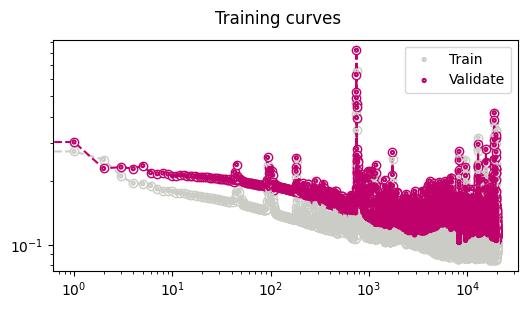

In [34]:
fig = trainer.plot_training_curves();
if SAVEFIGS:
    fig.savefig(plotfile('+U_training'), bbox_inches='tight')
fig.gca().set_xscale("log")

In [35]:
with torch.no_grad():
    train_predicted = hubbardml.engines.evaluate(trainer.best_model, trainer.train_loader).detach().cpu().numpy().reshape(-1)
    val_predicted = hubbardml.engines.evaluate(trainer.best_model, trainer.validate_loader).detach().cpu().numpy().reshape(-1)

df.loc[validate_idx, keys.PARAM_OUT_PREDICTED] = val_predicted
df.loc[train_idx, keys.PARAM_OUT_PREDICTED] = train_predicted

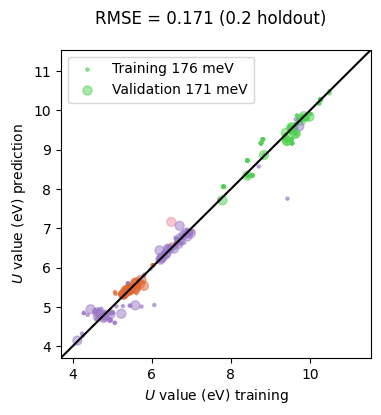

In [36]:
def rmse(y1, y2):
    return np.sqrt(((y1 - y2) ** 2).mean())


df_validate = df.loc[validate_idx]
validate_rmse = hubbardml.datasets.rmse(df_validate)
plots.create_parity_plot(df, title=f'RMSE = {validate_rmse:.3f} ({VALIDATE_PERCENTAGE} holdout)',
                         axis_label=f'${TARGET_PARAM}$ value (eV)');

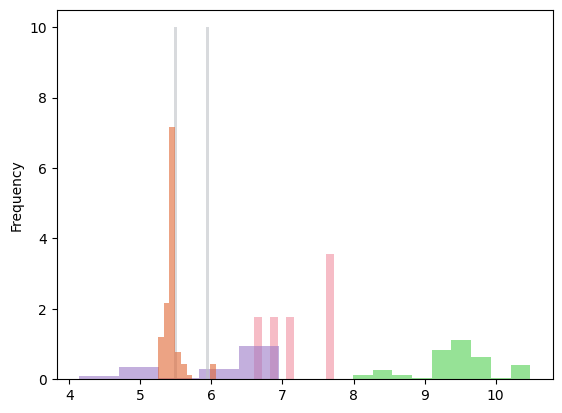

In [37]:
for label in df[keys.ATOM_1_ELEMENT].unique():
    frame = df[df[keys.LABEL] == label]
    series = frame[keys.PARAM_OUT_PREDICTED]
    ax = series.plot.hist(
        alpha=0.6,
        label=label,
        color=frame.iloc[0][keys.COLOUR],
        density=True,
        # histtype='step',
        xlabel="Energy difference (eV)",
        # bins=50,
        # range=(-0.4, 0.4),

    )

# Training

In [38]:
df_train = df.loc[train_idx]

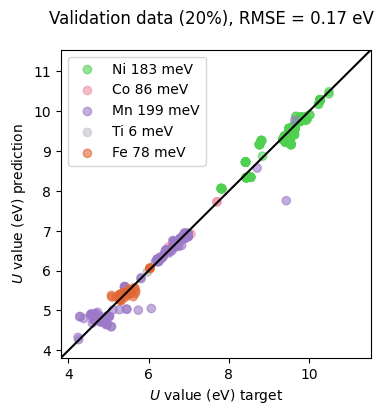

In [39]:
fig = plots.split_plot(df_train, keys.ATOM_1_ELEMENT,
                       axis_label='$U$ value (eV)',
                       title=f'Validation data ({VALIDATE_PERCENTAGE * 100:.0f}%), RMSE = {validate_rmse:.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('+U_parity_species'), bbox_inches='tight')

# Validation

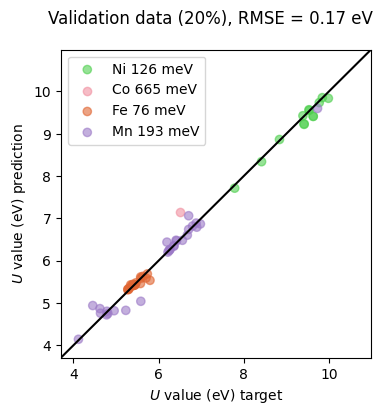

In [40]:
fig = plots.split_plot(df_validate, keys.ATOM_1_ELEMENT,
                       axis_label='$U$ value (eV)',
                       title=f'Validation data ({VALIDATE_PERCENTAGE * 100:.0f}%), RMSE = {validate_rmse:.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('+U_parity_species'), bbox_inches='tight')

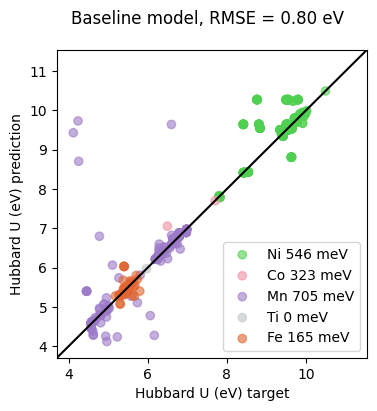

In [41]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(df_ref, keys.ATOM_1_ELEMENT, axis_label=f'Hubbard {TARGET_PARAM} (eV)',
                       title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref):.2f} eV');

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

In [42]:
df_ref = df.copy()
df_ref[keys.PARAM_OUT_PREDICTED] = df_ref[keys.PARAM_IN]
df_ref = df_ref[~(df_ref[keys.UV_ITER] == 1)]
fig = plots.split_plot(
    df_ref,
    keys.ATOM_1_ELEMENT,
    axis_label=f'Hubbard {TARGET_PARAM} (eV)',
    title=f'Baseline model, RMSE = {hubbardml.datasets.rmse(df_ref, label="both"):.2f} eV',
);

if SAVEFIGS:
    fig.savefig(plotfile('U_parity_species_ref'), bbox_inches='tight')

TypeError: rmse() got an unexpected keyword argument 'label'

In [ ]:
{str(pathlib.Path(directory).parent) for directory in df[keys.DIR].unique()}

In [ ]:
max_range = df[keys.PARAM_OUT].max() - df[keys.PARAM_OUT].min()
max_range = max(max_range, (df[keys.PARAM_OUT_PREDICTED].max() - df[keys.PARAM_OUT_PREDICTED].min()))
print(max_range)

plots.create_progression_plots(
    df,
    '/home/azadoks/Projects/uv_ml/data/iurii/Olivines/LiMnPO4/B2_Li0.25MnPO4/DFT_plus_UV',
    yrange=1.2
);

In [ ]:
if SAVEFIGS:
    idx = 0
    for figgroup in res:
        for fig in figgroup.values():
            fig.savefig(f'plots/hubbard_u/steps_{idx}_+U.pdf', bbox_inches='tight')
            idx += 1

In [ ]:
import copy

fig, ax = copy.deepcopy(model.tp1).cpu().visualize()
# ax.get_lines()[0].set_color('black')
for patch in ax.patches:
    patch.set_color(plots.plot_colours[2])

if SAVEFIGS:
    fig.savefig('plots/hubbard_u_tp.pdf', bbox_inches='tight')

In [ ]:
df[df[keys.PARAM_IN] == 0.][keys.TRAINING_LABEL]
